####  결정 트리 알고리즘을 활용한 와인 분류
- 한빛 마켓에서 캔 와인을 신상품으로 판매 시작, 레드 와인과 화이트 와인 표시가 누락
- 요구사항: 알코올 도수, 당도, PH 값으로 와인 종류 구별 가능?
- class 0(레드 와인), 1(화이트 와인)

와인 데이터 다운로드
- 캐글의 Red Wine Quality 데이터셋 일부
- https://bit.ly/wine_csv_data

#### 1. 데이터 탐색

In [1]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [2]:
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [3]:
# 총 6497개 샘플
# 4개의 Feature(알콜, 당도, PH, 와인 Class) => 모두 실수 값
# 누락 된 값 없음(Non Null)
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
alcohol    6497 non-null float64
sugar      6497 non-null float64
pH         6497 non-null float64
class      6497 non-null float64
dtypes: float64(4)
memory usage: 203.1 KB


In [4]:
# 알콜, 당도, PH 특징의 크기가 모두 제각각 => 정규화 필요
wine.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


#### 2.데이터 전처리

In [5]:
# numpy 형 변환
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

print(type(data))
print(type(target))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [6]:
from sklearn.model_selection import train_test_split

# 샘플 갯수가 충분해서 8:2 비율로 Train:Test 분리
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [7]:
print(train_input.shape, test_input.shape)

(5197, 3) (1300, 3)


In [8]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(train_input)

train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

#### 3.결정트리 모델
- 이유를 설명하기 쉬움(분류결과를 설명 가능한 모델)

In [16]:
# Train이 Test보다 좋은 성능(과대적합)

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion="gini", random_state=42)
dt.fit(train_scaled, train_target)

print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.996921300750433
0.8592307692307692


In [10]:
# 트리 모델 시각화
# - 트리모델은 나무를 거꾸로 한 형상
# - 맨 위가 루트 노드, 맨 아래가 리프 노드
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(10,7))
plot_tree(dt)
plt.show()

<Figure size 1000x700 with 1 Axes>

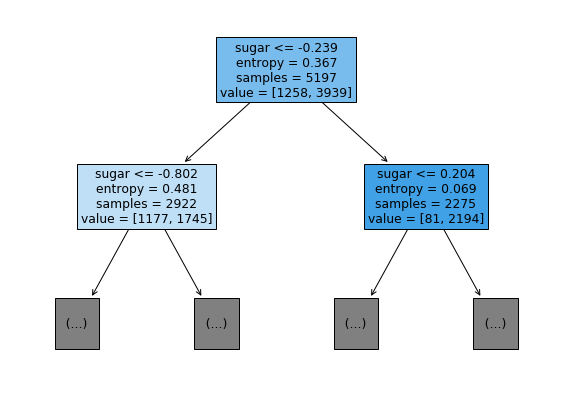

In [17]:
# 테스트 조건(sugar)
# 불순도(gini)
# 총 샘플 수(5197)
# 클래스별 샘플 수(1258, 3939)


# filled=True 옵션을 주면 클래스마다 색상 부여 및 어떤 클래스의 비율이 높아지면 점점 진한색으로 표시
plt.figure(figsize=(10,7))
plot_tree(dt, 
          max_depth=1, 
          filled=True, 
          feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

#### 불순도(gini 계수)

$지니 불순도 = 1 - (음성 클래스 비율^2 + 양성 클래스 비율^2)$

- 지니 계수의 최대 값은 0.5
- 지니계수가 0.5면 최악(클래스 모두 동일)
- 지니계수 0이면 순수 노드(하나의 클래스로 분류 됨)
- 분기 하였을 때 이러한 불순도값이 줄어드는 방향으로 학습

- 분기이전의 불순도와 분기 이후의 불순도의 차이를 정보 획득
- 불순도가 1인 상태에서 0.7인 상태로 바뀌면 정보 획득 0.3

#### 4.가지치기
- 열매가 잘 맺기 위해서 가지치기 하는 것처럼
- 트리모델도 가지치기 필요, 안그러면 무작정 끝까지 자라나는 트리 만들어짐(일반화 X)

> 결정트리에서 가지치기 방법은 자라날 수 있는 트리의 최대 깊이를 지정

In [23]:
# 훈련 세트 성능 낮아짐, 테스트 세트 성능은 그대로

dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_scaled, train_target)

print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.8454877814123533
0.8415384615384616


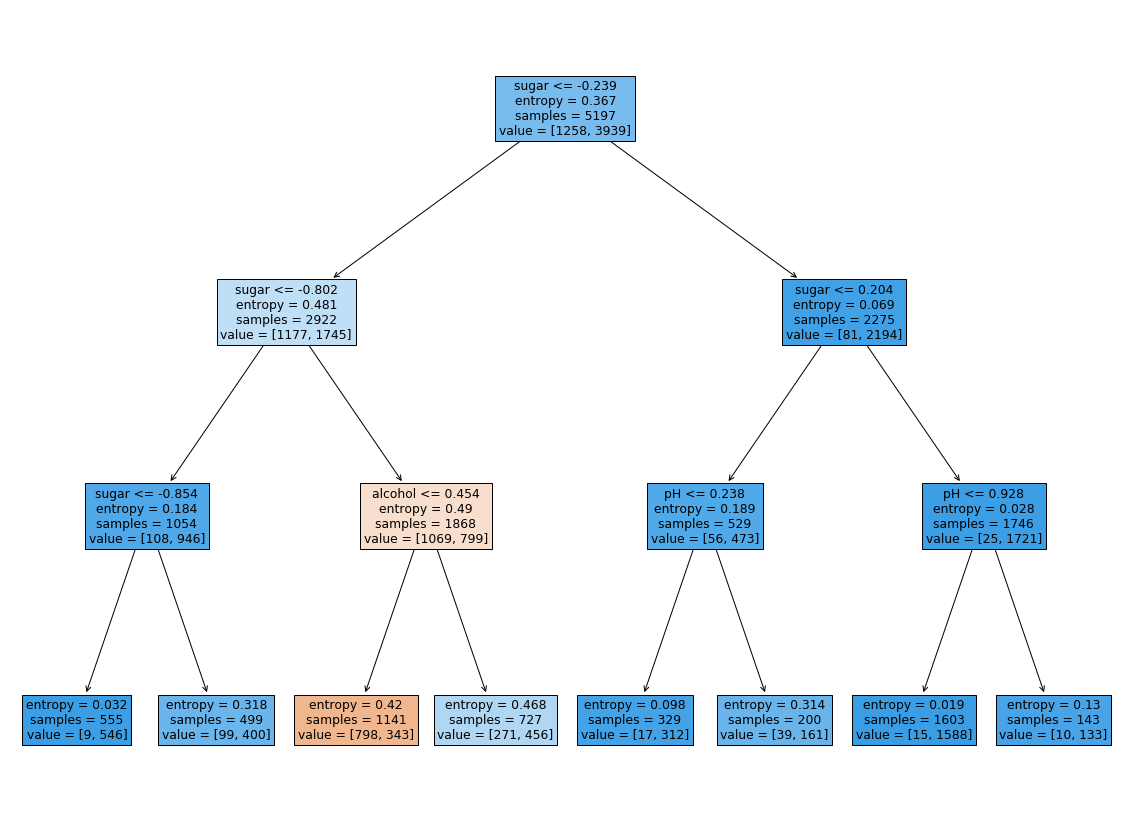

In [19]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

In [24]:
# 결정 트리 모델은 특징의 정규화 필요 없음
# - 트리 모델은 불순도 즉 클래스 비율로 계산
# - 특성값의 스케일은 결정 트리 모델이 전혀 필요 없음

dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_input, train_target)

print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

0.8454877814123533
0.8415384615384616


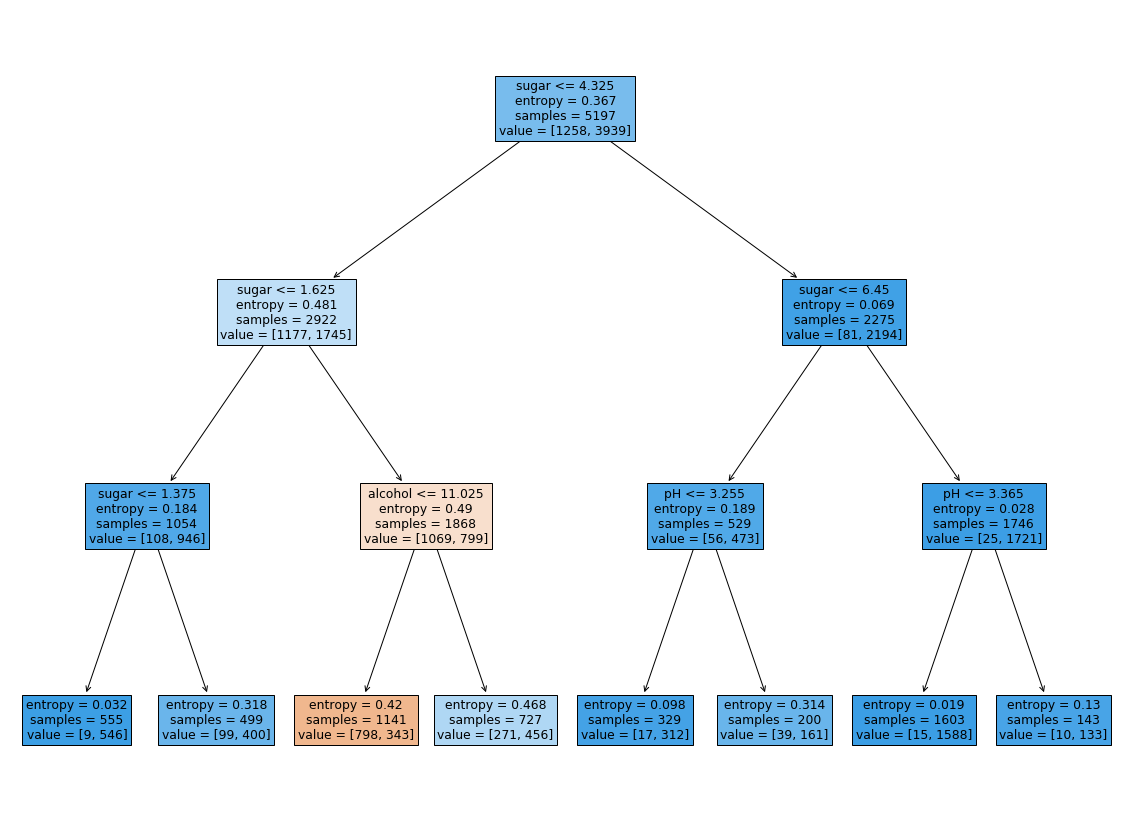

In [21]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

In [25]:
# 특성 중요도
# 알콜, 당도, PH
print(dt.feature_importances_)

[0.12345626 0.86862934 0.0079144 ]


#### 트리 모델의 단점
1. 과적합으로 알고리즘 성능 저하(트리의 크기를 사전에 제한하는 튜닝 필요)
2. 한번에 하나의 변수만 고려(변수간 상호작용 파악 어려움)
3. 약간의 차이에 따라 트리 모양이 많이 달라짐(두 변수가 비슷한 수준의 정보력, 약간의 차이로 다른 변수가 선택되면 이 후의 트리 구성이 크게 달라짐

=> 랜덤 포레스트 등장